# Advanced Predictions Using NBA Shot Charts
In this notebook, I supplement the features from the shot charts found through the NBA stats API with some additional features available for .csv download from NBAsavant.com and used this combined data set to better predict makes or misses.

In [1]:
import pandas as pd
import numpy as np

---
# Merge .csv data from NBAsavant.com with shot charts from NBA Stats API

In [2]:
# Read csv from downloaded NBAsavant.com
curry = pd.read_csv('Data/curry2010-18.csv')

# Sort shots in ascending order
curry = curry.sort_values(by=['game_date', 'period','minutes_remaining','seconds_remaining'], ascending=False)
curry = curry.sort_values(by=['game_date','period']).reset_index().drop(columns='index')
curry.head()

,name,team_name,game_date,season,espn_player_id,team_id,espn_game_id,period,minutes_remaining,seconds_remaining,...,shot_type,shot_distance,opponent,x,y,dribbles,touch_time,defender_name,defender_distance,shot_clock
0,Stephen Curry,Golden State Warriors,2010-10-27,2010,3975,1610612744,301027009.0,1,9,39,...,2PT Field Goal,16,Houston Rockets,13,167,NaN,NaN,NaN,NaN,NaN
1,Stephen Curry,Golden State Warriors,2010-10-27,2010,3975,1610612744,301027009.0,1,8,43,...,2PT Field Goal,15,Houston Rockets,159,14,NaN,NaN,NaN,NaN,NaN
2,Stephen Curry,Golden State Warriors,2010-10-27,2010,3975,1610612744,301027009.0,1,6,20,...,2PT Field Goal,16,Houston Rockets,-86,135,NaN,NaN,NaN,NaN,NaN
3,Stephen Curry,Golden State Warriors,2010-10-27,2010,3975,1610612744,301027009.0,1,4,52,...,2PT Field Goal,18,Houston Rockets,97,153,NaN,NaN,NaN,NaN,NaN
4,Stephen Curry,Golden State Warriors,2010-10-27,2010,3975,1610612744,301027009.0,1,1,39,...,3PT Field Goal,26,Houston Rockets,-152,214,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get info
curry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230 entries, 0 to 10229
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               10230 non-null  object 
 1   team_name          10230 non-null  object 
 2   game_date          10230 non-null  object 
 3   season             10230 non-null  int64  
 4   espn_player_id     10230 non-null  int64  
 5   team_id            10230 non-null  int64  
 6   espn_game_id       10213 non-null  float64
 7   period             10230 non-null  int64  
 8   minutes_remaining  10230 non-null  int64  
 9   seconds_remaining  10230 non-null  int64  
 10  shot_made_flag     10230 non-null  int64  
 11  action_type        10230 non-null  object 
 12  shot_type          10230 non-null  object 
 13  shot_distance      10230 non-null  int64  
 14  opponent           10230 non-null  object 
 15  x                  10230 non-null  int64  
 16  y                  102

In [4]:
# Filter only for dates where 'defender_name' is not null because the additional features are only available for a limited stretch of games between (2013-2016)
dates = curry[~curry['defender_name'].isna()].reset_index().drop(columns='index')

In [5]:
dates.isna().sum()

name                 0
team_name            0
game_date            0
season               0
espn_player_id       0
team_id              0
espn_game_id         0
period               0
minutes_remaining    0
seconds_remaining    0
shot_made_flag       0
action_type          0
shot_type            0
shot_distance        0
opponent             0
x                    0
y                    0
dribbles             0
touch_time           0
defender_name        0
defender_distance    0
shot_clock           0
dtype: int64

In [6]:
# Get a list of all the dates to match with the API
dates = dates['game_date'].unique().tolist()
len(dates)

224

In [7]:
from nba_api.stats.endpoints import shotchartdetail

# Import 2013-2014 shot charts from NBA API
df_1 = shotchartdetail.ShotChartDetail(
    team_id=1610612744,
    player_id=201939,
    season_nullable='2013-14',
    season_type_all_star = 'Regular Season',
    context_measure_simple = 'FGA').get_data_frames()[0]

# Import 2014-2015 shot charts from NBA API
df_2 = shotchartdetail.ShotChartDetail(
    team_id=1610612744,
    player_id=201939,
    season_nullable='2014-15',
    season_type_all_star = 'Regular Season',
    context_measure_simple = 'FGA').get_data_frames()[0]

# Import 2015-2016 shot charts from NBA API
df_3 = shotchartdetail.ShotChartDetail(
    team_id=1610612744,
    player_id=201939,
    season_nullable='2015-16',
    season_type_all_star = 'Regular Season',
    context_measure_simple = 'FGA').get_data_frames()[0]

# Concatenate all seasons
df = pd.concat([df_1, df_2, df_3])

# Convert date to match list of dates from .csv data
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df['GAME_DATE'] = df['GAME_DATE'].astype(str)

# Create placeholder list for games
df_list = []

# Loop over 224 dates from .csv data
for date in dates:
    
    # Append game to list
    df_list.append(df[df['GAME_DATE']==date])
    
# Concatenate list of games to one long dataframe 
df = pd.concat(df_list).reset_index().drop(columns='index')

# Remove 3164th entry -- after comparing the dataframes, this shot was missing from the .csv data
df = df.drop(3164)
df = df.reset_index().drop(columns='index')

# Keep features not found in .csv and time columns to compare entries are the same when concatenating 
df = df[['PERIOD','MINUTES_REMAINING','SECONDS_REMAINING','SHOT_ZONE_BASIC','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','GAME_DATE','HTM']]
df

,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,GAME_DATE,HTM
0,1,9,47,In The Paint (Non-RA),Center(C),Less Than 8 ft.,2013-10-30,GSW
1,1,5,34,In The Paint (Non-RA),Center(C),8-16 ft.,2013-10-30,GSW
2,1,2,11,Above the Break 3,Left Side Center(LC),24+ ft.,2013-10-30,GSW
3,2,6,37,Above the Break 3,Left Side Center(LC),24+ ft.,2013-10-30,GSW
4,2,3,8,Mid-Range,Left Side Center(LC),16-24 ft.,2013-10-30,GSW
...,...,...,...,...,...,...,...,...
3450,3,3,57,Above the Break 3,Center(C),24+ ft.,2016-01-20,CHI
3451,3,2,56,Above the Break 3,Right Side Center(RC),24+ ft.,2016-01-20,CHI
3452,3,0,9,Restricted Area,Center(C),Less Than 8 ft.,2016-01-20,CHI
3453,4,5,54,Above the Break 3,Center(C),24+ ft.,2016-01-20,CHI


In [8]:
# Those 224 dates returned 196 dates from the API - will use this list to match to the original .csv data frame to keep as many entries as possible
dates = df['GAME_DATE'].unique().tolist()
len(dates)

196

In [9]:
# Create placeholder list for games
df_list = []

# Loop over new dates
for date in dates:
    
    # Find matching dates from original .csv data
    df_list.append(curry[curry['game_date']==date])
    
# Concatenate games to one long dataframe    
df_ = pd.concat(df_list).reset_index().drop(columns='index')
df_

,name,team_name,game_date,season,espn_player_id,team_id,espn_game_id,period,minutes_remaining,seconds_remaining,...,shot_type,shot_distance,opponent,x,y,dribbles,touch_time,defender_name,defender_distance,shot_clock
0,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,9,47,...,2PT Field Goal,5,Los Angeles Lakers,-52,26,10.0,7.5,"Gasol, Pau",5.3,16.3
1,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,5,34,...,2PT Field Goal,13,Los Angeles Lakers,-65,121,3.0,2.8,"Blake, Steve",3.4,19.3
2,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,2,11,...,3PT Field Goal,26,Los Angeles Lakers,-144,228,6.0,5.3,"Farmar, Jordan",3.0,16.8
3,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,2,6,37,...,3PT Field Goal,25,Los Angeles Lakers,-86,244,6.0,5.5,"Farmar, Jordan",5.4,16.7
4,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,2,3,8,...,2PT Field Goal,20,Los Angeles Lakers,-130,153,9.0,8.8,"Blake, Steve",3.3,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,3,57,...,3PT Field Goal,24,Chicago Bulls,17,249,14.0,9.0,"Brooks, Aaron",5.4,13.0
3451,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,2,56,...,3PT Field Goal,24,Chicago Bulls,137,203,0.0,0.6,"McDermott, Doug",3.4,8.3
3452,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,0,9,...,2PT Field Goal,0,Chicago Bulls,0,1,21.0,19.4,"Butler, Jimmy",6.5,5.1
3453,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,4,5,54,...,3PT Field Goal,25,Chicago Bulls,40,252,2.0,2.2,"Butler, Jimmy",4.8,13.2


In [10]:
# Merge .csv data with additional features from NBA API
df = pd.concat([df_, df], axis=1)
df

,name,team_name,game_date,season,espn_player_id,team_id,espn_game_id,period,minutes_remaining,seconds_remaining,...,defender_distance,shot_clock,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,GAME_DATE,HTM
0,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,9,47,...,5.3,16.3,1,9,47,In The Paint (Non-RA),Center(C),Less Than 8 ft.,2013-10-30,GSW
1,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,5,34,...,3.4,19.3,1,5,34,In The Paint (Non-RA),Center(C),8-16 ft.,2013-10-30,GSW
2,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,2,11,...,3.0,16.8,1,2,11,Above the Break 3,Left Side Center(LC),24+ ft.,2013-10-30,GSW
3,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,2,6,37,...,5.4,16.7,2,6,37,Above the Break 3,Left Side Center(LC),24+ ft.,2013-10-30,GSW
4,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,2,3,8,...,3.3,14.4,2,3,8,Mid-Range,Left Side Center(LC),16-24 ft.,2013-10-30,GSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,3,57,...,5.4,13.0,3,3,57,Above the Break 3,Center(C),24+ ft.,2016-01-20,CHI
3451,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,2,56,...,3.4,8.3,3,2,56,Above the Break 3,Right Side Center(RC),24+ ft.,2016-01-20,CHI
3452,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,0,9,...,6.5,5.1,3,0,9,Restricted Area,Center(C),Less Than 8 ft.,2016-01-20,CHI
3453,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,4,5,54,...,4.8,13.2,4,5,54,Above the Break 3,Center(C),24+ ft.,2016-01-20,CHI


In [11]:
# Entries appear to be in agreement so dropping redundant columns
df = df.drop(columns=['PERIOD','MINUTES_REMAINING','SECONDS_REMAINING','GAME_DATE'])

In [12]:
# Check final dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3455 entries, 0 to 3454
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               3455 non-null   object 
 1   team_name          3455 non-null   object 
 2   game_date          3455 non-null   object 
 3   season             3455 non-null   int64  
 4   espn_player_id     3455 non-null   int64  
 5   team_id            3455 non-null   int64  
 6   espn_game_id       3455 non-null   float64
 7   period             3455 non-null   int64  
 8   minutes_remaining  3455 non-null   int64  
 9   seconds_remaining  3455 non-null   int64  
 10  shot_made_flag     3455 non-null   int64  
 11  action_type        3455 non-null   object 
 12  shot_type          3455 non-null   object 
 13  shot_distance      3455 non-null   int64  
 14  opponent           3455 non-null   object 
 15  x                  3455 non-null   int64  
 16  y                  3455 

Now we have one dataframe with 3455 entries (as many as possible that match between the entries with additional features from the .csv file and the NBA stats API).

---
# Feature engineering

In [13]:
# Getting a list of the games to loop through
games = df['espn_game_id'].unique().tolist()

# Creating a placeholder list to append each games' dataframe back to after manipulation
df_list = []

# Looping over the list of games
for game in games:
    
    # Create a dataframe for game
    shot_df = df[df['espn_game_id']==game].reset_index().drop(columns='index')
    
    # Create new column 'follows_make' that identifies shots following a made shot
    shot_df['follows_make'] = shot_df['shot_made_flag'].shift()
    shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)
    
    # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
    shot_df['follows_streak'] = shot_df.shot_made_flag.ne(shot_df['shot_made_flag'].shift())
    shot_df['follows_streak'] = shot_df['follows_streak'].shift()
    shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
    shot_df['follows_streak'] = ~shot_df['follows_streak']

    # Intermediate columns to identify streaks of makes or misses
    shot_df['new1'] = shot_df.follows_streak.eq(shot_df.shot_made_flag.shift())
    shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

    # Create new columns 'follows_two_makes'
    shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
    shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

    # Create new columns 'follows_two_misses'
    shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
    shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

    # Drop intermediate columns
    shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
    
    # Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
    shot_df['follows_streak'] = (shot_df.shot_made_flag == shot_df.shot_made_flag.shift()) & (shot_df.shot_made_flag.shift() == shot_df.shot_made_flag.shift().shift())
    shot_df['follows_streak'] = shot_df['follows_streak'].shift()
    shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

    # Intermediate columns to identify streaks of makes or misses
    shot_df['new1'] = shot_df.follows_streak.eq(shot_df.shot_made_flag.shift())
    shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

    # Create new columns 'follows_three_makes' and 'success_following_three_makes'
    shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
    shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

    # Create new columns 'follows_three_misses' and 'success_following_three_misses'
    shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
    shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

    # Drop intermediate columns
    shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
        
    # Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
    shot_df['follows_streak'] = (shot_df.shot_made_flag == shot_df.shot_made_flag.shift()) & (shot_df.shot_made_flag.shift() == shot_df.shot_made_flag.shift().shift()) & (shot_df.shot_made_flag.shift() == shot_df.shot_made_flag.shift().shift().shift())
    shot_df['follows_streak'] = shot_df['follows_streak'].shift()
    shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

    # Intermediate columns to identify streaks of makes or misses
    shot_df['new1'] = shot_df.follows_streak.eq(shot_df.shot_made_flag.shift())
    shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

    # Create new columns 'follows_two_makes' and 'success_following_two_makes'
    shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
    shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

    # Create new columns 'follows_four_misses' and 'success_following_four_misses'
    shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
    shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

    # Drop intermediate columns
    shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
    
    # Append game to list
    df_list.append(shot_df)
    
# Concatenate all back to one long dataframe
shot_df = pd.concat(df_list).reset_index().drop(columns='index')
shot_df

,name,team_name,game_date,season,espn_player_id,team_id,espn_game_id,period,minutes_remaining,seconds_remaining,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,HTM,follows_make,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses,follows_four_makes,follows_four_misses
0,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,9,47,...,Center(C),Less Than 8 ft.,GSW,0,0,0,0,0,0,0
1,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,5,34,...,Center(C),8-16 ft.,GSW,1,0,0,0,0,0,0
2,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,1,2,11,...,Left Side Center(LC),24+ ft.,GSW,0,0,0,0,0,0,0
3,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,2,6,37,...,Left Side Center(LC),24+ ft.,GSW,0,0,1,0,0,0,0
4,Stephen Curry,Golden State Warriors,2013-10-30,2013,3975,1610612744,400488890.0,2,3,8,...,Left Side Center(LC),16-24 ft.,GSW,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,3,57,...,Center(C),24+ ft.,CHI,0,0,0,0,0,0,0
3451,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,2,56,...,Right Side Center(RC),24+ ft.,CHI,0,0,1,0,0,0,0
3452,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,3,0,9,...,Center(C),Less Than 8 ft.,CHI,1,0,0,0,0,0,0
3453,Stephen Curry,Golden State Warriors,2016-01-20,2015,3975,1610612744,400828521.0,4,5,54,...,Center(C),24+ ft.,CHI,1,1,0,0,0,0,0


In [14]:
# Check info
shot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3455 entries, 0 to 3454
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  3455 non-null   object 
 1   team_name             3455 non-null   object 
 2   game_date             3455 non-null   object 
 3   season                3455 non-null   int64  
 4   espn_player_id        3455 non-null   int64  
 5   team_id               3455 non-null   int64  
 6   espn_game_id          3455 non-null   float64
 7   period                3455 non-null   int64  
 8   minutes_remaining     3455 non-null   int64  
 9   seconds_remaining     3455 non-null   int64  
 10  shot_made_flag        3455 non-null   int64  
 11  action_type           3455 non-null   object 
 12  shot_type             3455 non-null   object 
 13  shot_distance         3455 non-null   int64  
 14  opponent              3455 non-null   object 
 15  x                    

In [15]:
# Drop unneccesary columns
shot_df = shot_df.drop(columns=['name', 'team_name' ,'game_date' , 'season', 'espn_player_id', 'team_id', 'espn_game_id'])
shot_df

,period,minutes_remaining,seconds_remaining,shot_made_flag,action_type,shot_type,shot_distance,opponent,x,y,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,HTM,follows_make,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses,follows_four_makes,follows_four_misses
0,1,9,47,1,Floating Jump shot,2PT Field Goal,5,Los Angeles Lakers,-52,26,...,Center(C),Less Than 8 ft.,GSW,0,0,0,0,0,0,0
1,1,5,34,0,Fadeaway Jump Shot,2PT Field Goal,13,Los Angeles Lakers,-65,121,...,Center(C),8-16 ft.,GSW,1,0,0,0,0,0,0
2,1,2,11,0,Jump Shot,3PT Field Goal,26,Los Angeles Lakers,-144,228,...,Left Side Center(LC),24+ ft.,GSW,0,0,0,0,0,0,0
3,2,6,37,1,Pullup Jump shot,3PT Field Goal,25,Los Angeles Lakers,-86,244,...,Left Side Center(LC),24+ ft.,GSW,0,0,1,0,0,0,0
4,2,3,8,0,Pullup Jump shot,2PT Field Goal,20,Los Angeles Lakers,-130,153,...,Left Side Center(LC),16-24 ft.,GSW,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,3,57,0,Jump Shot,3PT Field Goal,24,Chicago Bulls,17,249,...,Center(C),24+ ft.,CHI,0,0,0,0,0,0,0
3451,3,2,56,1,Jump Shot,3PT Field Goal,24,Chicago Bulls,137,203,...,Right Side Center(RC),24+ ft.,CHI,0,0,1,0,0,0,0
3452,3,0,9,1,Driving Dunk Shot,2PT Field Goal,0,Chicago Bulls,0,1,...,Center(C),Less Than 8 ft.,CHI,1,0,0,0,0,0,0
3453,4,5,54,1,Jump Shot,3PT Field Goal,25,Chicago Bulls,40,252,...,Center(C),24+ ft.,CHI,1,1,0,0,0,0,0


In [16]:
# Convert time to a single metric 'time_remaining_secs'
shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
shot_df = shot_df.drop(columns=['minutes_remaining', 'seconds_remaining'])
shot_df

,period,shot_made_flag,action_type,shot_type,shot_distance,opponent,x,y,dribbles,touch_time,...,SHOT_ZONE_RANGE,HTM,follows_make,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses,follows_four_makes,follows_four_misses,time_remaining_secs
0,1,1,Floating Jump shot,2PT Field Goal,5,Los Angeles Lakers,-52,26,10.0,7.5,...,Less Than 8 ft.,GSW,0,0,0,0,0,0,0,587
1,1,0,Fadeaway Jump Shot,2PT Field Goal,13,Los Angeles Lakers,-65,121,3.0,2.8,...,8-16 ft.,GSW,1,0,0,0,0,0,0,334
2,1,0,Jump Shot,3PT Field Goal,26,Los Angeles Lakers,-144,228,6.0,5.3,...,24+ ft.,GSW,0,0,0,0,0,0,0,131
3,2,1,Pullup Jump shot,3PT Field Goal,25,Los Angeles Lakers,-86,244,6.0,5.5,...,24+ ft.,GSW,0,0,1,0,0,0,0,397
4,2,0,Pullup Jump shot,2PT Field Goal,20,Los Angeles Lakers,-130,153,9.0,8.8,...,16-24 ft.,GSW,1,0,0,0,0,0,0,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,Jump Shot,3PT Field Goal,24,Chicago Bulls,17,249,14.0,9.0,...,24+ ft.,CHI,0,0,0,0,0,0,0,237
3451,3,1,Jump Shot,3PT Field Goal,24,Chicago Bulls,137,203,0.0,0.6,...,24+ ft.,CHI,0,0,1,0,0,0,0,176
3452,3,1,Driving Dunk Shot,2PT Field Goal,0,Chicago Bulls,0,1,21.0,19.4,...,Less Than 8 ft.,CHI,1,0,0,0,0,0,0,9
3453,4,1,Jump Shot,3PT Field Goal,25,Chicago Bulls,40,252,2.0,2.2,...,24+ ft.,CHI,1,1,0,0,0,0,0,354


In [17]:
# One hot encode 'action_type' column
action_type_df = pd.get_dummies(shot_df['action_type']).iloc[:,1:]
action_type_df

,Cutting Finger Roll Layup Shot,Cutting Layup Shot,Driving Bank shot,Driving Dunk Shot,Driving Finger Roll Layup Shot,Driving Floating Bank Jump Shot,Driving Floating Jump Shot,Driving Hook Shot,Driving Jump shot,Driving Layup Shot,...,Running Reverse Layup Shot,Running Slam Dunk Shot,Slam Dunk Shot,Step Back Jump shot,Tip Shot,Turnaround Bank shot,Turnaround Fadeaway Bank Jump Shot,Turnaround Fadeaway shot,Turnaround Hook Shot,Turnaround Jump Shot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3452,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Concatenate 'action_type' and 'shot_df' and drop original 'action_type' column
shot_df = pd.concat([shot_df, action_type_df], axis=1).drop(columns='action_type')
shot_df

,period,shot_made_flag,shot_type,shot_distance,opponent,x,y,dribbles,touch_time,defender_name,...,Running Reverse Layup Shot,Running Slam Dunk Shot,Slam Dunk Shot,Step Back Jump shot,Tip Shot,Turnaround Bank shot,Turnaround Fadeaway Bank Jump Shot,Turnaround Fadeaway shot,Turnaround Hook Shot,Turnaround Jump Shot
0,1,1,2PT Field Goal,5,Los Angeles Lakers,-52,26,10.0,7.5,"Gasol, Pau",...,0,0,0,0,0,0,0,0,0,0
1,1,0,2PT Field Goal,13,Los Angeles Lakers,-65,121,3.0,2.8,"Blake, Steve",...,0,0,0,0,0,0,0,0,0,0
2,1,0,3PT Field Goal,26,Los Angeles Lakers,-144,228,6.0,5.3,"Farmar, Jordan",...,0,0,0,0,0,0,0,0,0,0
3,2,1,3PT Field Goal,25,Los Angeles Lakers,-86,244,6.0,5.5,"Farmar, Jordan",...,0,0,0,0,0,0,0,0,0,0
4,2,0,2PT Field Goal,20,Los Angeles Lakers,-130,153,9.0,8.8,"Blake, Steve",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,3PT Field Goal,24,Chicago Bulls,17,249,14.0,9.0,"Brooks, Aaron",...,0,0,0,0,0,0,0,0,0,0
3451,3,1,3PT Field Goal,24,Chicago Bulls,137,203,0.0,0.6,"McDermott, Doug",...,0,0,0,0,0,0,0,0,0,0
3452,3,1,2PT Field Goal,0,Chicago Bulls,0,1,21.0,19.4,"Butler, Jimmy",...,0,0,0,0,0,0,0,0,0,0
3453,4,1,3PT Field Goal,25,Chicago Bulls,40,252,2.0,2.2,"Butler, Jimmy",...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Create new column to distinguish 2 pointers from 3 pointers
shot_df['3PT Field Goal'] = pd.get_dummies(shot_df['shot_type']).iloc[:,1]
shot_df = shot_df.drop(columns='shot_type')
shot_df

,period,shot_made_flag,shot_distance,opponent,x,y,dribbles,touch_time,defender_name,defender_distance,...,Running Slam Dunk Shot,Slam Dunk Shot,Step Back Jump shot,Tip Shot,Turnaround Bank shot,Turnaround Fadeaway Bank Jump Shot,Turnaround Fadeaway shot,Turnaround Hook Shot,Turnaround Jump Shot,3PT Field Goal
0,1,1,5,Los Angeles Lakers,-52,26,10.0,7.5,"Gasol, Pau",5.3,...,0,0,0,0,0,0,0,0,0,0
1,1,0,13,Los Angeles Lakers,-65,121,3.0,2.8,"Blake, Steve",3.4,...,0,0,0,0,0,0,0,0,0,0
2,1,0,26,Los Angeles Lakers,-144,228,6.0,5.3,"Farmar, Jordan",3.0,...,0,0,0,0,0,0,0,0,0,1
3,2,1,25,Los Angeles Lakers,-86,244,6.0,5.5,"Farmar, Jordan",5.4,...,0,0,0,0,0,0,0,0,0,1
4,2,0,20,Los Angeles Lakers,-130,153,9.0,8.8,"Blake, Steve",3.3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,Chicago Bulls,17,249,14.0,9.0,"Brooks, Aaron",5.4,...,0,0,0,0,0,0,0,0,0,1
3451,3,1,24,Chicago Bulls,137,203,0.0,0.6,"McDermott, Doug",3.4,...,0,0,0,0,0,0,0,0,0,1
3452,3,1,0,Chicago Bulls,0,1,21.0,19.4,"Butler, Jimmy",6.5,...,0,0,0,0,0,0,0,0,0,0
3453,4,1,25,Chicago Bulls,40,252,2.0,2.2,"Butler, Jimmy",4.8,...,0,0,0,0,0,0,0,0,0,1


In [20]:
# One hot encode 'opponent' column
opponent_df = pd.get_dummies(shot_df['opponent'], 'Opponent:', ' ').iloc[:,1:]
opponent_df

,Opponent: Boston Celtics,Opponent: Brooklyn Nets,Opponent: Charlotte Hornets,Opponent: Chicago Bulls,Opponent: Cleveland Cavaliers,Opponent: Dallas Mavericks,Opponent: Denver Nuggets,Opponent: Detroit Pistons,Opponent: Houston Rockets,Opponent: Indiana Pacers,...,Opponent: Oklahoma City Thunder,Opponent: Orlando Magic,Opponent: Philadelphia 76ers,Opponent: Phoenix Suns,Opponent: Portland Trail Blazers,Opponent: Sacramento Kings,Opponent: San Antonio Spurs,Opponent: Toronto Raptors,Opponent: Utah Jazz,Opponent: Washington Wizards
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3451,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3452,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3453,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Concatenate 'opponent_df' and shot_df' and drop original 'opponent' column
shot_df = pd.concat([shot_df, opponent_df], axis=1).drop(columns='opponent')
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_name,defender_distance,shot_clock,...,Opponent: Oklahoma City Thunder,Opponent: Orlando Magic,Opponent: Philadelphia 76ers,Opponent: Phoenix Suns,Opponent: Portland Trail Blazers,Opponent: Sacramento Kings,Opponent: San Antonio Spurs,Opponent: Toronto Raptors,Opponent: Utah Jazz,Opponent: Washington Wizards
0,1,1,5,-52,26,10.0,7.5,"Gasol, Pau",5.3,16.3,...,0,0,0,0,0,0,0,0,0,0
1,1,0,13,-65,121,3.0,2.8,"Blake, Steve",3.4,19.3,...,0,0,0,0,0,0,0,0,0,0
2,1,0,26,-144,228,6.0,5.3,"Farmar, Jordan",3.0,16.8,...,0,0,0,0,0,0,0,0,0,0
3,2,1,25,-86,244,6.0,5.5,"Farmar, Jordan",5.4,16.7,...,0,0,0,0,0,0,0,0,0,0
4,2,0,20,-130,153,9.0,8.8,"Blake, Steve",3.3,14.4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,17,249,14.0,9.0,"Brooks, Aaron",5.4,13.0,...,0,0,0,0,0,0,0,0,0,0
3451,3,1,24,137,203,0.0,0.6,"McDermott, Doug",3.4,8.3,...,0,0,0,0,0,0,0,0,0,0
3452,3,1,0,0,1,21.0,19.4,"Butler, Jimmy",6.5,5.1,...,0,0,0,0,0,0,0,0,0,0
3453,4,1,25,40,252,2.0,2.2,"Butler, Jimmy",4.8,13.2,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Convert coordinates to positive values for min/max scaling
shot_df['x'] = shot_df['x']+250
shot_df['y'] = shot_df['y']+30
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_name,defender_distance,shot_clock,...,Opponent: Oklahoma City Thunder,Opponent: Orlando Magic,Opponent: Philadelphia 76ers,Opponent: Phoenix Suns,Opponent: Portland Trail Blazers,Opponent: Sacramento Kings,Opponent: San Antonio Spurs,Opponent: Toronto Raptors,Opponent: Utah Jazz,Opponent: Washington Wizards
0,1,1,5,198,56,10.0,7.5,"Gasol, Pau",5.3,16.3,...,0,0,0,0,0,0,0,0,0,0
1,1,0,13,185,151,3.0,2.8,"Blake, Steve",3.4,19.3,...,0,0,0,0,0,0,0,0,0,0
2,1,0,26,106,258,6.0,5.3,"Farmar, Jordan",3.0,16.8,...,0,0,0,0,0,0,0,0,0,0
3,2,1,25,164,274,6.0,5.5,"Farmar, Jordan",5.4,16.7,...,0,0,0,0,0,0,0,0,0,0
4,2,0,20,120,183,9.0,8.8,"Blake, Steve",3.3,14.4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,267,279,14.0,9.0,"Brooks, Aaron",5.4,13.0,...,0,0,0,0,0,0,0,0,0,0
3451,3,1,24,387,233,0.0,0.6,"McDermott, Doug",3.4,8.3,...,0,0,0,0,0,0,0,0,0,0
3452,3,1,0,250,31,21.0,19.4,"Butler, Jimmy",6.5,5.1,...,0,0,0,0,0,0,0,0,0,0
3453,4,1,25,290,282,2.0,2.2,"Butler, Jimmy",4.8,13.2,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Convert 'dribbles' to integer type
shot_df['dribbles'] = shot_df['dribbles'].astype(int)

In [24]:
# One hot encode 'defender_name' column
defender_df = pd.get_dummies(shot_df['defender_name'], 'Defender:', ' ').iloc[:,1:]
defender_df

,"Defender: Adams, Steven","Defender: Adrien, Jeff","Defender: Afflalo, Arron","Defender: Ajinca, Alexis","Defender: Aldridge, LaMarcus","Defender: Allen, Lavoy","Defender: Allen, Ray","Defender: Allen, Tony","Defender: Aminu, Al-Farouq","Defender: Amundson, Lou",...,"Defender: Winslow, Justise","Defender: Withey, Jeff","Defender: Wolters, Nate","Defender: Wright, Brandan","Defender: Wright, Dorell","Defender: Wroten, Tony","Defender: Young, Nick","Defender: Young, Thaddeus","Defender: Zeller, Cody","Defender: Zeller, Tyler"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Concatenate 'defender_df' and shot_df' and drop original 'defender_name' column
shot_df = pd.concat([shot_df, defender_df], axis=1).drop(columns='defender_name')
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_distance,shot_clock,SHOT_ZONE_BASIC,...,"Defender: Winslow, Justise","Defender: Withey, Jeff","Defender: Wolters, Nate","Defender: Wright, Brandan","Defender: Wright, Dorell","Defender: Wroten, Tony","Defender: Young, Nick","Defender: Young, Thaddeus","Defender: Zeller, Cody","Defender: Zeller, Tyler"
0,1,1,5,198,56,10,7.5,5.3,16.3,In The Paint (Non-RA),...,0,0,0,0,0,0,0,0,0,0
1,1,0,13,185,151,3,2.8,3.4,19.3,In The Paint (Non-RA),...,0,0,0,0,0,0,0,0,0,0
2,1,0,26,106,258,6,5.3,3.0,16.8,Above the Break 3,...,0,0,0,0,0,0,0,0,0,0
3,2,1,25,164,274,6,5.5,5.4,16.7,Above the Break 3,...,0,0,0,0,0,0,0,0,0,0
4,2,0,20,120,183,9,8.8,3.3,14.4,Mid-Range,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,267,279,14,9.0,5.4,13.0,Above the Break 3,...,0,0,0,0,0,0,0,0,0,0
3451,3,1,24,387,233,0,0.6,3.4,8.3,Above the Break 3,...,0,0,0,0,0,0,0,0,0,0
3452,3,1,0,250,31,21,19.4,6.5,5.1,Restricted Area,...,0,0,0,0,0,0,0,0,0,0
3453,4,1,25,290,282,2,2.2,4.8,13.2,Above the Break 3,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# One hot encode 'SHOT_ZONE_BASIC' column
shot_zone_basic_df = pd.get_dummies(shot_df['SHOT_ZONE_BASIC']).iloc[:,[0,2,3,4,5,6]]
shot_zone_basic_df

,Above the Break 3,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
3450,1,0,0,0,0,0
3451,1,0,0,0,0,0
3452,0,0,0,0,1,0
3453,1,0,0,0,0,0


In [27]:
# Concatenate 'shot_zone_basic_df' and shot_df' and drop original 'SHOT_ZONE_BASIC' column
shot_df = pd.concat([shot_df, shot_zone_basic_df], axis=1).drop(columns='SHOT_ZONE_BASIC')
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_distance,shot_clock,SHOT_ZONE_AREA,...,"Defender: Young, Nick","Defender: Young, Thaddeus","Defender: Zeller, Cody","Defender: Zeller, Tyler",Above the Break 3,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3
0,1,1,5,198,56,10,7.5,5.3,16.3,Center(C),...,0,0,0,0,0,1,0,0,0,0
1,1,0,13,185,151,3,2.8,3.4,19.3,Center(C),...,0,0,0,0,0,1,0,0,0,0
2,1,0,26,106,258,6,5.3,3.0,16.8,Left Side Center(LC),...,0,0,0,0,1,0,0,0,0,0
3,2,1,25,164,274,6,5.5,5.4,16.7,Left Side Center(LC),...,0,0,0,0,1,0,0,0,0,0
4,2,0,20,120,183,9,8.8,3.3,14.4,Left Side Center(LC),...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,267,279,14,9.0,5.4,13.0,Center(C),...,0,0,0,0,1,0,0,0,0,0
3451,3,1,24,387,233,0,0.6,3.4,8.3,Right Side Center(RC),...,0,0,0,0,1,0,0,0,0,0
3452,3,1,0,250,31,21,19.4,6.5,5.1,Center(C),...,0,0,0,0,0,0,0,0,1,0
3453,4,1,25,290,282,2,2.2,4.8,13.2,Center(C),...,0,0,0,0,1,0,0,0,0,0


In [28]:
# One hot encode 'SHOT_ZONE_AREA' column
shot_zone_area_df = pd.get_dummies(shot_df['SHOT_ZONE_AREA']).iloc[:,1:]
shot_zone_area_df

,Center(C),Left Side Center(LC),Left Side(L),Right Side Center(RC),Right Side(R)
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
3450,1,0,0,0,0
3451,0,0,0,1,0
3452,1,0,0,0,0
3453,1,0,0,0,0


In [29]:
# Concatenate 'shot_zone_area_df' and shot_df' and drop original 'SHOT_ZONE_AREA' column
shot_df = pd.concat([shot_df, shot_zone_area_df], axis=1).drop(columns='SHOT_ZONE_AREA')
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_distance,shot_clock,SHOT_ZONE_RANGE,...,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3,Center(C),Left Side Center(LC),Left Side(L),Right Side Center(RC),Right Side(R)
0,1,1,5,198,56,10,7.5,5.3,16.3,Less Than 8 ft.,...,1,0,0,0,0,1,0,0,0,0
1,1,0,13,185,151,3,2.8,3.4,19.3,8-16 ft.,...,1,0,0,0,0,1,0,0,0,0
2,1,0,26,106,258,6,5.3,3.0,16.8,24+ ft.,...,0,0,0,0,0,0,1,0,0,0
3,2,1,25,164,274,6,5.5,5.4,16.7,24+ ft.,...,0,0,0,0,0,0,1,0,0,0
4,2,0,20,120,183,9,8.8,3.3,14.4,16-24 ft.,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,267,279,14,9.0,5.4,13.0,24+ ft.,...,0,0,0,0,0,1,0,0,0,0
3451,3,1,24,387,233,0,0.6,3.4,8.3,24+ ft.,...,0,0,0,0,0,0,0,0,1,0
3452,3,1,0,250,31,21,19.4,6.5,5.1,Less Than 8 ft.,...,0,0,0,1,0,1,0,0,0,0
3453,4,1,25,290,282,2,2.2,4.8,13.2,24+ ft.,...,0,0,0,0,0,1,0,0,0,0


In [30]:
# One hot encode 'SHOT_ZONE_RANGE' column
shot_zone_range_df = pd.get_dummies(shot_df['SHOT_ZONE_RANGE']).iloc[:,[0,1,2,4,]]
shot_zone_range_df

,16-24 ft.,24+ ft.,8-16 ft.,Less Than 8 ft.
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0
...,...,...,...,...
3450,0,1,0,0
3451,0,1,0,0
3452,0,0,0,1
3453,0,1,0,0


In [31]:
# Concatenate 'shot_zone_range_df' and shot_df' and drop original 'SHOT_ZONE_RANGE' column
shot_df = pd.concat([shot_df, shot_zone_range_df], axis=1).drop(columns='SHOT_ZONE_RANGE')
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_distance,shot_clock,HTM,...,Right Corner 3,Center(C),Left Side Center(LC),Left Side(L),Right Side Center(RC),Right Side(R),16-24 ft.,24+ ft.,8-16 ft.,Less Than 8 ft.
0,1,1,5,198,56,10,7.5,5.3,16.3,GSW,...,0,1,0,0,0,0,0,0,0,1
1,1,0,13,185,151,3,2.8,3.4,19.3,GSW,...,0,1,0,0,0,0,0,0,1,0
2,1,0,26,106,258,6,5.3,3.0,16.8,GSW,...,0,0,1,0,0,0,0,1,0,0
3,2,1,25,164,274,6,5.5,5.4,16.7,GSW,...,0,0,1,0,0,0,0,1,0,0
4,2,0,20,120,183,9,8.8,3.3,14.4,GSW,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,267,279,14,9.0,5.4,13.0,CHI,...,0,1,0,0,0,0,0,1,0,0
3451,3,1,24,387,233,0,0.6,3.4,8.3,CHI,...,0,0,0,0,1,0,0,1,0,0
3452,3,1,0,250,31,21,19.4,6.5,5.1,CHI,...,0,1,0,0,0,0,0,0,0,1
3453,4,1,25,290,282,2,2.2,4.8,13.2,CHI,...,0,1,0,0,0,0,0,1,0,0


In [32]:
# Categorically encode home games
shot_df['home_game'] = shot_df['HTM']=='GSW'
shot_df['home_game'] = shot_df['home_game'].astype(int)
shot_df = shot_df.drop(columns='HTM')
shot_df

,period,shot_made_flag,shot_distance,x,y,dribbles,touch_time,defender_distance,shot_clock,follows_make,...,Center(C),Left Side Center(LC),Left Side(L),Right Side Center(RC),Right Side(R),16-24 ft.,24+ ft.,8-16 ft.,Less Than 8 ft.,home_game
0,1,1,5,198,56,10,7.5,5.3,16.3,0,...,1,0,0,0,0,0,0,0,1,1
1,1,0,13,185,151,3,2.8,3.4,19.3,1,...,1,0,0,0,0,0,0,1,0,1
2,1,0,26,106,258,6,5.3,3.0,16.8,0,...,0,1,0,0,0,0,1,0,0,1
3,2,1,25,164,274,6,5.5,5.4,16.7,0,...,0,1,0,0,0,0,1,0,0,1
4,2,0,20,120,183,9,8.8,3.3,14.4,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,3,0,24,267,279,14,9.0,5.4,13.0,0,...,1,0,0,0,0,0,1,0,0,0
3451,3,1,24,387,233,0,0.6,3.4,8.3,0,...,0,0,0,1,0,0,1,0,0,0
3452,3,1,0,250,31,21,19.4,6.5,5.1,1,...,1,0,0,0,0,0,0,0,1,0
3453,4,1,25,290,282,2,2.2,4.8,13.2,1,...,1,0,0,0,0,0,1,0,0,0


---
# EDA

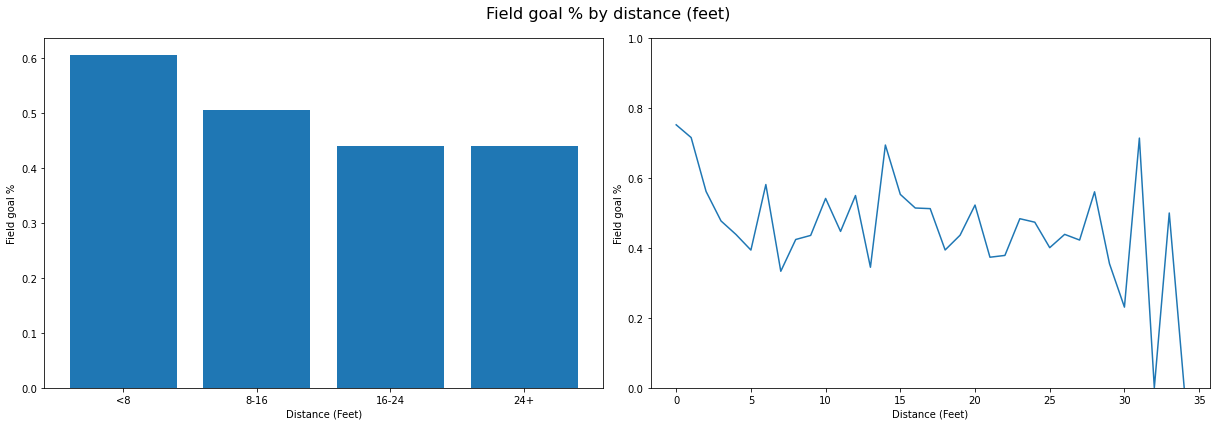

In [243]:
import matplotlib.pyplot as plt

# Create subplots for field goal % by distance
plt.subplots(1,2, figsize=(17, 6))
plt.suptitle('Field goal % by distance (feet)', fontsize=16)

# Bar plot for field goal % by binned distances
plt.subplot(1,2,1)
plt.xlabel('Distance (Feet)')
plt.ylabel('Field goal %')
plt.bar(['<8','8-16','16-24','24+'],[shot_df[shot_df['Less Than 8 ft.']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Less Than 8 ft.']==1]),
                           shot_df[shot_df['8-16 ft.']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['8-16 ft.']==1]),
                           shot_df[shot_df['16-24 ft.']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['16-24 ft.']==1]),
                           shot_df[shot_df['24+ ft.']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['24+ ft.']==1])])

# Create a placeholder lists for percentages
pct_list = []

# Loop through distances 0-35 feet
for i in range(0,35):
    
    # Calculate the shooting percentage at that distance and append to list
    pct_list.append(shot_df[shot_df['shot_distance']==i]['shot_made_flag'].sum()/len(shot_df[shot_df['shot_distance']==i]))
    
# Plot field goal % by distance in feet
plt.subplot(1,2,2)
plt.plot(range(0,35), pct_list)
plt.xlabel('Distance (Feet)')
plt.ylabel('Field goal %')
plt.ylim(0,1)

plt.tight_layout()
plt.show()

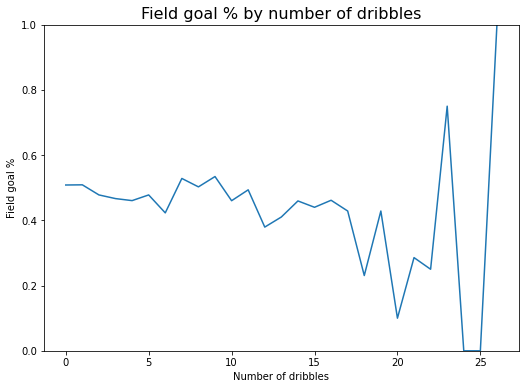

In [260]:
# Plot field goal % by number of dribbles
plt.figure(figsize=(8.5,6))
plt.title('Field goal % by number of dribbles', fontsize=16)

# Create a placeholder lists for percentages
pct_list = []

# Loop through number of dribbles 0-26 feet
for i in range(0,27):
    
    # Calculate the shooting percentage and append to list
    pct_list.append(shot_df[shot_df['dribbles']==i]['shot_made_flag'].sum()/len(shot_df[shot_df['dribbles']==i]))
    
# Plot shooting percentages by number of dribbles
plt.plot(range(0,27), pct_list)
plt.xlabel('Number of dribbles')
plt.ylabel('Field goal %')
plt.ylim(0,1)

plt.show()

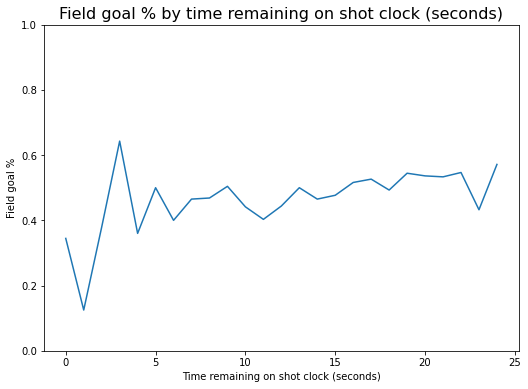

In [293]:
# Put unique values of 'touch_time' in a sorted list
shot_clock = round(shot_df['shot_clock']).sort_values().unique().tolist()

# Plot field goal % by time remaining on shot clock (seconds)
plt.figure(figsize=(8.5,6))
plt.title('Field goal % by time remaining on shot clock (seconds)', fontsize=16)

# Create a placeholder lists for percentages
pct_list = []

# Loop through the list of unique 'defender_distance' values
for i in shot_clock:
    
    # Calculate the shooting percentage and append to list
    pct_list.append(shot_df[round(shot_df['shot_clock'])==i]['shot_made_flag'].sum()/len(shot_df[round(shot_df['shot_clock'])==i]))
    
# Plot shooting percentages by touch time
plt.plot(shot_clock, pct_list)
plt.xlabel('Time remaining on shot clock (seconds)')
plt.ylabel('Field goal %')
plt.ylim(0,1)

plt.show()

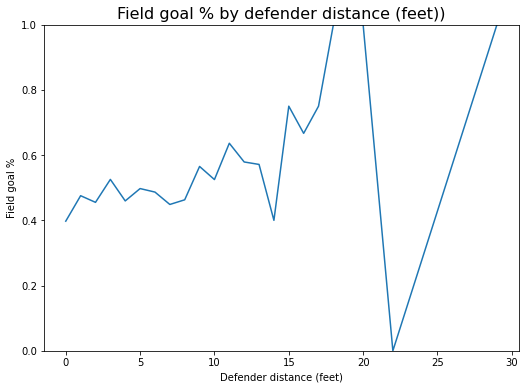

In [296]:
# Put unique values of 'defender_distance' in a sorted list
defender_distance = round(shot_df['defender_distance']).sort_values().unique().tolist()

# Plot field goal % by defender distance (feet)
plt.figure(figsize=(8.5,6))
plt.title('Field goal % by defender distance (feet))', fontsize=16)

# Create a placeholder lists for percentages
pct_list = []

# Loop through the list of unique 'defender_distance' values
for i in defender_distance:
    
    # Calculate the shooting percentage and append to list
    pct_list.append(shot_df[round(shot_df['defender_distance'])==i]['shot_made_flag'].sum()/len(shot_df[round(shot_df['defender_distance'])==i]))
    
# Plot shooting percentages by touch time
plt.plot(defender_distance, pct_list)
plt.xlabel('Defender distance (feet)')
plt.ylabel('Field goal %')
plt.ylim(0,1)

plt.show()

In [297]:
3/13

0.23076923076923078

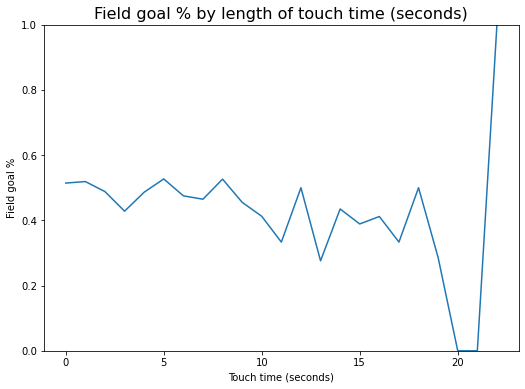

In [295]:
# Put unique values of 'touch_time' in a sorted list
touch_time = round(shot_df['touch_time']).sort_values().unique().tolist()

# Plot field goal % by length of touch time (seconds)
plt.figure(figsize=(8.5,6))
plt.title('Field goal % by length of touch time (seconds)', fontsize=16)

# Create a placeholder lists for percentages
pct_list = []

# Loop through the list of unique 'touch time' values
for i in touch_time:
    
    # Calculate the shooting percentage at that distance and append to list
    pct_list.append(shot_df[round(shot_df['touch_time'])==i]['shot_made_flag'].sum()/len(shot_df[round(shot_df['touch_time']==i]))
    
# Plot shooting percentages by distance in feet
plt.plot(touch_time, pct_list)
plt.xlabel('Touch time (seconds)')
plt.ylabel('Field goal %')
plt.ylim(0,1)

plt.show()

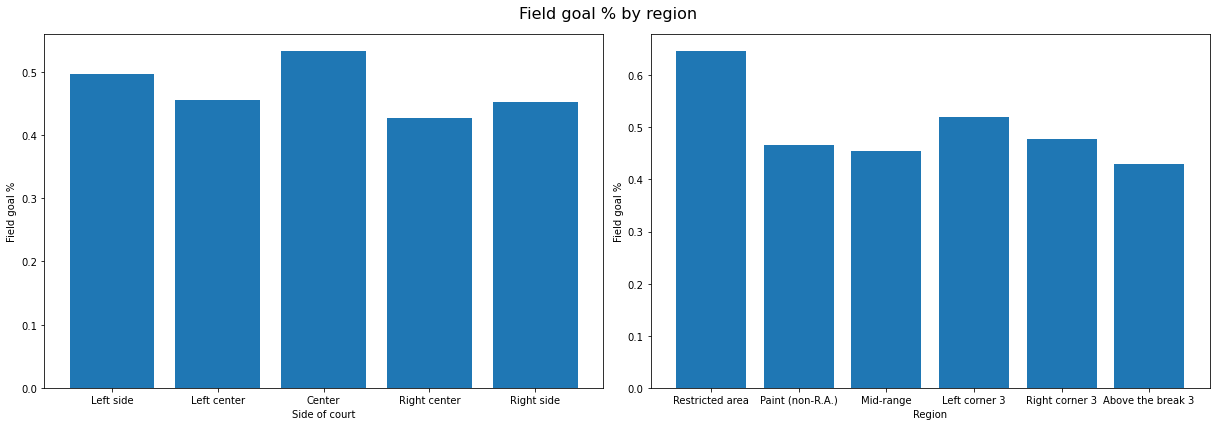

In [246]:
# Create subplots for field goal % by region
plt.subplots(1,2, figsize=(17, 6))
plt.suptitle('Field goal % by region', fontsize=16)

# Plot field goal % by side of court
plt.subplot(1,2,1)
plt.xlabel('Side of court')
plt.ylabel('Field goal %')
plt.bar(['Left side','Left center','Center','Right center','Right side'],[shot_df[shot_df['Left Side(L)']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Left Side(L)']==1]),
                       shot_df[shot_df['Left Side Center(LC)']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Left Side Center(LC)']==1]),
                       shot_df[shot_df['Center(C)']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Center(C)']==1]),
                       shot_df[shot_df['Right Side Center(RC)']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Right Side Center(RC)']==1]),
                       shot_df[shot_df['Right Side(R)']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Right Side(R)']==1])])

# Plot field goal % by region
plt.subplot(1,2,2)
plt.xlabel('Region')
plt.ylabel('Field goal %')
plt.bar(['Restricted area','Paint (non-R.A.)','Mid-range','Left corner 3','Right corner 3', 'Above the break 3'],
        [shot_df[shot_df['Restricted Area']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Restricted Area']==1]),
         shot_df[shot_df['In The Paint (Non-RA)']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['In The Paint (Non-RA)']==1]),
         shot_df[shot_df['Mid-Range']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Mid-Range']==1]),
         shot_df[shot_df['Left Corner 3']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Left Corner 3']==1]),
         shot_df[shot_df['Right Corner 3']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Right Corner 3']==1]),
         shot_df[shot_df['Above the Break 3']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['Above the Break 3']==1])])

plt.tight_layout()
plt.show()

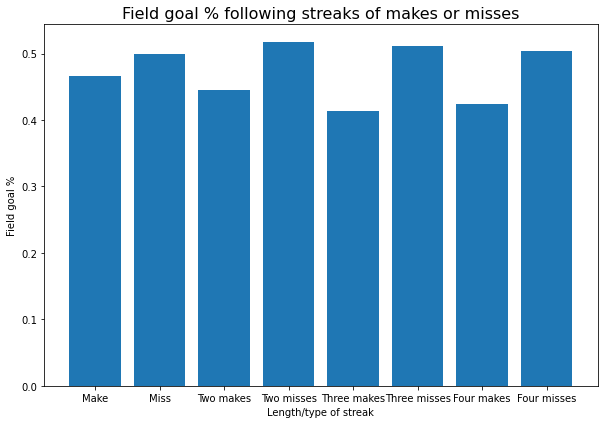

In [250]:
# Plot field foal % following streaks of makes or misses
plt.figure(figsize=(8.5,6))
plt.title('Field goal % following streaks of makes or misses', fontsize=16)

plt.xlabel('Length/type of streak')
plt.ylabel('Field goal %')
plt.bar(['Make','Miss','Two makes','Two misses','Three makes','Three misses','Four makes','Four misses'],
        [shot_df[shot_df['follows_make']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_make']==1]),
         shot_df[shot_df['follows_make']==0]['shot_made_flag'].sum()/(len(shot_df[shot_df['follows_make']==0]-1)),
         shot_df[shot_df['follows_two_makes']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_two_makes']==1]),
         shot_df[shot_df['follows_two_misses']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_two_misses']==1]),
         shot_df[shot_df['follows_three_makes']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_three_makes']==1]),
         shot_df[shot_df['follows_three_misses']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_three_misses']==1]),
         shot_df[shot_df['follows_four_makes']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_four_makes']==1]),
         shot_df[shot_df['follows_four_misses']==1]['shot_made_flag'].sum()/len(shot_df[shot_df['follows_four_misses']==1])])

plt.tight_layout()
plt.show()

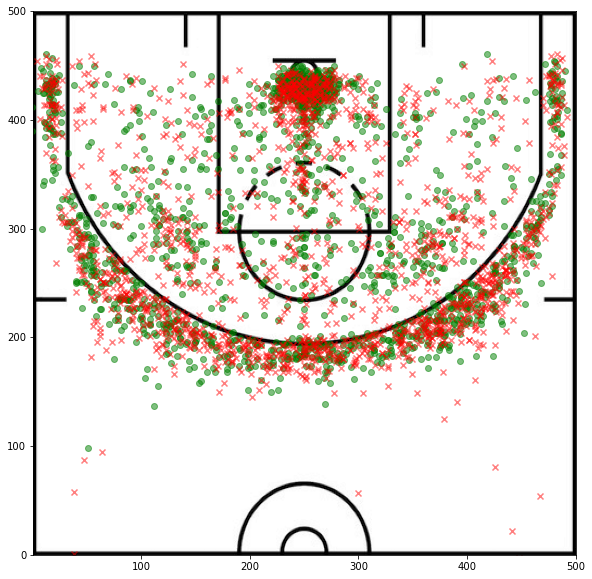

In [244]:
# Plot all makes and misses
img = plt.imread("court.png")

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, extent=[1, 500, -1, 499])
ax.scatter(shot_df[shot_df['shot_made_flag']==1]['x'], 470-shot_df[shot_df['shot_made_flag']==1]['y'], marker='o', c='g', alpha=0.5)
ax.scatter(shot_df[shot_df['shot_made_flag']==0]['x'], 470-shot_df[shot_df['shot_made_flag']==0]['y'], marker='x', c='r', alpha=0.5)
plt.xlim(1,500)
plt.ylim(0,500)
plt.show()

I'd like to explore creating some more interesting visuals using the location of shots.

---
# Defining X and Y

In [212]:
# Define X and y
X = shot_df.drop(columns = ['shot_made_flag'])
y = shot_df['shot_made_flag']

# Confirm the shapes
print(X.shape)
print(y.shape)

(3455, 510)
(3455,)


---
# Train/test split

In [213]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15)
# Confirm the shapes
print(f' X_train shape: {X_train.shape}')
print(f' y_train shape: {y_train.shape}\n')
print(f' X_test shape: {X_test.shape}')
print(f' y_test shape: {y_test.shape}')

 X_train shape: (2936, 510)
 y_train shape: (2936,)

 X_test shape: (519, 510)
 y_test shape: (519,)


---
# Logistic Regression

In [214]:
from sklearn.linear_model import LogisticRegression

# Fit a vanilla logistic regression on data
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train, y_train)

# Score on train and test sets
print(f'Training accuracy: {log_reg.score(X_train, y_train)}')
print(f'Test accuracy: {log_reg.score(X_test, y_test)}')

Training accuracy: 0.6437329700272479
Test accuracy: 0.6416184971098265


/Users/jordanfresque/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [215]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Define estimators for pipeline
estimators = [('scale', MinMaxScaler()),
             ('PCA', PCA()),
             ('model', LogisticRegression())]

# Create a pipeline
pipe = Pipeline(estimators)

In [216]:
from sklearn.model_selection import GridSearchCV

# Define parameters for grid search
param_grid = [{'model': [LogisticRegression(solver='lbfgs')],
               'scale': [MinMaxScaler(), None],
               'PCA': [PCA(n_components=0.8), None],
               'model__penalty': ['l2', None],
               'model__C': list(np.logspace(-5,5,11))}]

# Create a gridsearch
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

In [217]:
# Fit gridsearch on training data
fitted_grid = grid.fit(X_train, y_train)

# Display best parameters
fitted_grid.best_params_

Fitting 5 folds for each of 88 candidates, totalling 440 fits


/Users/jordanfresque/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/jordanfresque/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.5156677  0.51737128        nan        nan 0.5156677  0.51873298
        nan        nan 0.59331954 0.51907369        nan        nan
 0.61751324 0.51907369        nan        nan 0.63147794 0.51907369
        nan        nan 0.63181576 0.51907369        nan        nan
 0.63113433 0.51907369        nan        nan 0.63079303 0.51907369
        nan        nan 0.63079303 0.51907369        nan        nan
 0.63079303 0.51907369        nan        nan 0.63079303 0.51907369
        nan        nan 0.5156677  0.57220098        nan        nan
 0.5156677  0.57799198        

{'PCA': None,
 'model': LogisticRegression(C=0.1),
 'model__C': 0.1,
 'model__penalty': 'l2',
 'scale': MinMaxScaler()}

In [218]:
# Apply min/max scaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

# Fit logistic regression on min/max scaled training data
log_reg = LogisticRegression(solver='lbfgs', penalty='l2', C=0.1)
log_reg = log_reg.fit(X_train_mm, y_train)

# Score on train and test sets
print(f'Training accuracy: {log_reg.score(X_train_mm, y_train)}')
print(f'Test accuracy: {log_reg.score(X_test_mm, y_test)}')

Training accuracy: 0.6767711171662125
Test accuracy: 0.6763005780346821


---
# Model Evaluation

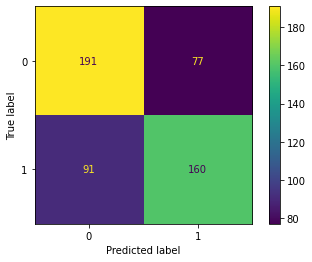

In [219]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate and plot the confusion matrix
conf_mat = confusion_matrix(y_test, log_reg.predict(X_test_mm))
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

In [220]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, log_reg.predict(X_test_mm))
print(report_initial)

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       268
           1       0.68      0.64      0.66       251

    accuracy                           0.68       519
   macro avg       0.68      0.68      0.68       519
weighted avg       0.68      0.68      0.68       519



In [221]:
# Put the coefficients into a DataFrame
coefs = pd.DataFrame(data=log_reg.coef_, columns=X_train.columns).T
coefs = coefs.rename(columns={0: 'coefs'})

# Display the 10 most positive coefs
coefs.sort_values(by='coefs', ascending=False).head(10)

,coefs
defender_distance,0.692503
Running Bank shot,0.670192
Driving Finger Roll Layup Shot,0.597804
shot_clock,0.472953
Driving Reverse Layup Shot,0.413782
"Defender: Burke, Trey",0.368598
24+ ft.,0.315986
"Defender: Williams, Mo",0.289452
"Defender: Chalmers, Mario",0.284636
Restricted Area,0.282984


In [222]:
# Display the 10 most negative coefs
coefs.sort_values(by='coefs', ascending=True).head(10)

,coefs
Jump Shot,-1.251410
Layup Shot,-1.181601
touch_time,-0.497957
home_game,-0.462304
"Defender: Rose, Derrick",-0.452109
"Defender: Farmar, Jordan",-0.372438
Driving Jump shot,-0.366078
y,-0.323589
"Defender: Blake, Steve",-0.267991
shot_distance,-0.257802


With a lot more features to train the model on, the accuracy improved substantially (67% on test data) compared to our baseline (55% on test data). The optimized model managed to accurately predict a few more misses (71% recall) than makes (64% recall) but had nearly identical precision for both classes (68%). The model was able to learn some pretty valuable insights that agree with exploratory data analysis. For example, being separated from a defender and having ample time left on the shot clock are predictive of a make. Conversely, the longer Steph holds the ball, the more dribbles he takes, and the further away from the basket he is, the less likely he is to score.

---
# Decision Tree

In [223]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 4)
dt = dt.fit(X_train, y_train)

# Print accuracy scores
print(f'Training accuracy: {dt.score(X_train, y_train)}')
print(f'Test accuracy: {dt.score(X_test, y_test)}')

Training accuracy: 0.6600817438692098
Test accuracy: 0.6763005780346821


I also played around with tree style classifiers a bit but they didn't do much better than the logistic regression. I opted to stick with the logistic regression for ease of interpretability.

---
# XG Boost

In [225]:
import xgboost
from xgboost import XGBClassifier

# Fit model on training data
xgb = XGBClassifier(n_estimators=1300, max_depth=3, learning_rate=0.001, gamma=2.2, subsample=0.7, colsample_bytree=0.6, reg_lambda=0.6)
xgb = xgb.fit(X_train, y_train)

# Print accuracy scores
print(f'Training accuracy: {xgb.score(X_train, y_train)}')
print(f'Test accuracy: {xgb.score(X_test, y_test)}')

[13:34:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jordanfresque/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training accuracy: 0.6617847411444142
Test accuracy: 0.6878612716763006


---